## [요구사항 1] titanic_dataset.py 분석 리포트

## class TitanicDataset(Dataset)
- PyTorch의 Dataset을 상속받아 타이타닉 데이터를 텐서로 관리하는 기능 구현
- 입력 피쳐 x, 타겟 lable의 y를 받아, 데이터셋의 샘플을 하나씩 접근할 수 있는 입력 메서드 정의

In [790]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class TitanicDataset(Dataset):
  def __init__(self, X, y):
    # X는 입력 피쳐, y는 타겟 레이블
    self.X = torch.FloatTensor(X)
    self.y = torch.LongTensor(y)  # 타겟을 LongTensor로 변환

  def __len__(self):
    # 데이터셋의 전체 샘플 수 반환.
    return len(self.X)

  def __getitem__(self, idx):
    # 주어진 인덱스에 해당하는 샘플 반환.
    feature = self.X[idx]
    target = self.y[idx]
    return {'input': feature, 'target': target}

  def __str__(self):
    # 데이터셋의 크기, 입력, 타겟의 shape의 정보 반환.
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str

## class Titanic TestDataset(Dataset)
테스트 데이터셋을 위한 클래스. 테스트 데이터는 타겟 값이 없어 입력 피쳐 값만 관리함.

In [792]:
class TitanicDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X)
    self.y = torch.FloatTensor(y)

  def __len__(self):
    # 데이터셋의 전체 샘플 수 반환.
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    target = self.y[idx] if self.y is not None else None  # None 체크 추가
    return {'input': feature, 'target': target}

  def __str__(self):
    # 데이터셋의 크기와 입력 피쳐의 shapte
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape
    )
    return str

## def get_preprocessed_dataset()
- 이 함수는 타이타닉 데이터를 불러와서 전처리한 후에 학습, 검증, 테스트 데이터셋으로 나눔.
- 각 전처리 단계는 이후 정의된 전처리 함수들에서 처리함.

In [794]:
def get_preprocessed_dataset():
    #CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
    CURRENT_FILE_PATH = os.getcwd()  # 주피터 환경에 최적화하기 위해 수정. 현재 작업 디렉토리를 사용

    # 타이타닉 데이터 로드
    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    # 학습 및 테스트 데이터를 하나의 데이터 프레임으로 합쳐서 전처리함.
    all_df = pd.concat([train_df, test_df], sort = False)

    # 각 전처리 단계 함수를 호출함.
    all_df = get_preprocessed_dataset_1(all_df)
    all_df = get_preprocessed_dataset_2(all_df)
    all_df = get_preprocessed_dataset_3(all_df)
    all_df = get_preprocessed_dataset_4(all_df)
    all_df = get_preprocessed_dataset_5(all_df)
    all_df = get_preprocessed_dataset_6(all_df)

    # 타겟 값이 있는 행은 학습 데이터, 없는 행은 테스트 데이터로 분리함.
    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    # PyTorch Dataset으로 변환함.
    dataset = TitanicDataset(train_X.values, train_y.values)
    #print(dataset)
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)

    return train_dataset, validation_dataset, test_dataset

## def get_preprocessed_dataset_1(all_df) ~ 6
전처리 함수

In [796]:
def get_preprocessed_dataset_1(all_df):
    # 전처리 함수
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]

    return all_df

In [797]:
def get_preprocessed_dataset_2(all_df):
    # 전처리 함수
    # name을 세 개의 컬럼(family_name, honorific, name으로 분리하여 다시 all_df에 합침)
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "honorific", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df

In [798]:
def get_preprocessed_dataset_3(all_df):
    # 전처리 함수
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    return all_df

In [799]:
def get_preprocessed_dataset_4(all_df):
    # 전처리 함수
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    #all_df["alone"].fillna(0, inplace=True)
    all_df["alone"] = all_df["alone"].fillna(0) # 경고문을 방지하기 위해 수정함.

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df

In [800]:
def get_preprocessed_dataset_5(all_df):
    # 전처리 함수
    # honorific 값 개수 줄이기
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),
    "honorific"
    ] = "other"
    #all_df["Embarked"].fillna("missing", inplace=True)
    all_df["Embarked"] = all_df["Embarked"].fillna("missing") # 경고문을 방지하기 위해 수정함.

    return all_df

In [801]:
def get_preprocessed_dataset_6(all_df):
    # 전처리 함수
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
          le = le.fit(all_df[category_feature])
          all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df

## class MyModel(nn.Module)
- MyModel은 신경망 모델 클래스로 torch.nn.Module을 상속 받아 사용함.
- 입력 크기가 n_input인 3개의 Ninear 레이어와 활성화 함수인 ReLu를 사용함.

In [803]:
from torch import nn
class MyModel(nn.Module):
  def __init__(self, n_input, n_output):
    super().__init__()

    self.model = nn.Sequential(
      nn.Linear(n_input, 30),
      nn.ReLU(),
      nn.Linear(30, 30),
      nn.ReLU(),
      nn.Linear(30, n_output),
    )

  def forward(self, x):
    x = self.model(x)
    return x

## def test(test_data_loader)
- test 함수는 테스트 데이터를 모델에 통과시켜 예측 결과를 출력하는 역할임.
- test_data_loader에서 배치 하나를 가져와서 입력 데이터를 신경망 모델에 통과하고 출력 값을 얻음.
- 출력 값에서 가장 높은 확률을 가진 클레스를 예측하고, 해당 결과를 892번부터 출력함.

In [805]:
def test(test_data_loader):
  print("[TEST]")
  batch = next(iter(test_data_loader))    # 테스트 데이터에서 배치를 하나 가져옴
  print("{0}".format(batch['input'].shape)) # 배치 입력 데이터의 형태 출력
  my_model = MyModel(n_input=11, n_output=2) # 11개의 입력과 2개의 출력을 갖는 모델 생성
  output_batch = my_model(batch['input']) # 모델에 입력 데이터를 넣고 예측값을 얻음
  prediction_batch = torch.argmax(output_batch, dim=1) # 각 예측값에서 가장 높은 확률의 클래스 예측
  for idx, prediction in enumerate(prediction_batch, start=892):
      print(idx, prediction.item()) # 892번부터 예측값 출력

## if __name__ == "__main__":
- 전처리된 train, validation, test 데이터셋을 생성하여, 이를 DataLoader에 넣어 학습과 테스트를 준비함.
- train_data_loader와 validation_data_loader는 각각 학습과 검증을 위한 데이터셋 로더.
- 배치 크기는 16
- 학습과 검증 데이터의 배치 출력
- test_data_loader를 통해 테스트 데이터를 사용하여 예측 결과 출력.

In [807]:
if __name__ == "__main__":
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

  print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
    len(train_dataset), len(validation_dataset), len(test_dataset)
  ))
  print("#" * 50, 1)

  for idx, sample in enumerate(train_dataset):
    print("{0} - {1}: {2}".format(idx, sample['input'], sample['target']))

  print("#" * 50, 2)

  train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=True)
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

  print("[TRAIN]")
  for idx, batch in enumerate(train_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("[VALIDATION]")
  for idx, batch in enumerate(validation_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("#" * 50, 3)

  test(test_data_loader)

train_dataset: 713, validation_dataset.shape: 178, test_dataset: 418
################################################## 1
0 - tensor([ 3.0000,  1.0000, 12.0000,  1.0000,  0.0000, 11.2417,  0.0000, 13.3029,
         0.0000,  1.0000,  0.0000]): 1.0
1 - tensor([ 1.0000,  0.0000, 47.0000,  1.0000,  1.0000, 52.5542,  2.0000, 87.5090,
         3.0000,  2.0000,  0.0000]): 1.0
2 - tensor([ 3.0000,  1.0000, 27.0000,  0.0000,  0.0000,  7.8958,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0.0
3 - tensor([ 3.0000,  1.0000, 15.0000,  1.0000,  1.0000,  7.2292,  0.0000, 13.3029,
         2.0000,  2.0000,  0.0000]): 0.0
4 - tensor([ 1.0000,  1.0000, 54.0000,  0.0000,  0.0000, 51.8625,  2.0000, 87.5090,
         2.0000,  0.0000,  1.0000]): 0.0
5 - tensor([ 2.0000,  1.0000, 25.0000,  1.0000,  0.0000, 26.0000,  2.0000, 21.1792,
         2.0000,  1.0000,  0.0000]): 0.0
6 - tensor([ 3.0000,  1.0000,  3.0000,  1.0000,  1.0000, 15.9000,  2.0000, 13.3029,
         0.0000,  2.0000,  0.0000]): 1.0
7 -

AttributeError: 'TitanicTestDataset' object has no attribute 'y'

## [요구사항 2] titanic 딥러닝 모델 훈련 코드 및 Activation Function 변경해보기
- d_my_model_training_with_argparse_wandb.py 코드를 그대로 활용하되, titanic 데이터에 맞게 수정하여 그려내기.

- Wandb로 훈련 과정 데이터 올려 그래프 얻어내기
  • Training loss
  • Validation loss
  • 위 두 그래프를 보여주는 Wandb URL 얻어내기

- 모델 구성 내에 Activation Function를 변경하여 더 나은 성능을 산출하는 Activation Function이 있는지 조사하기<br>
  • ReLU<br>
  • ELU<br>
  • Leaky ReLU<br>
  • PReLU<br>
  • ...

ELU
•
Leaky
ReLU
•
PReLU

#### 코드 d_my_model_training_with_argparse_wandb.py의 Wandb URL
https://wandb.ai/oieunxe-korea-university-of-technology-and-education/my_model_training/runs/0bgf97tb?nw=nwuseroieunxe

#### d_my_model_training_with_argparse_wandb.py 코드를 그대로 활용하되, titanic 데이터에 맞게 수정하여 그려낸 그래프 Wandb URL
https://wandb.ai/oieunxe-korea-university-of-technology-and-education/titanic_model_training?nw=nwuseroieunxe



#### 모델 구성 내에 Activation Function을 변경하였음. ReLU, ELU, Leaky ReLU, PReLU 모델을 사용함.
#### 네 모델을 순차적으로 사용하여 출력한 Wandb URL 및 이미지
https://wandb.ai/oieunxe-korea-university-of-technology-and-education/titanic_model_training?nw=nwuseroieunxe

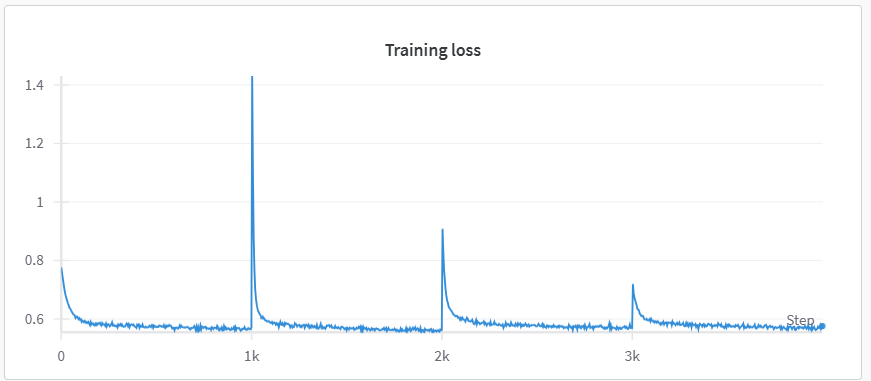
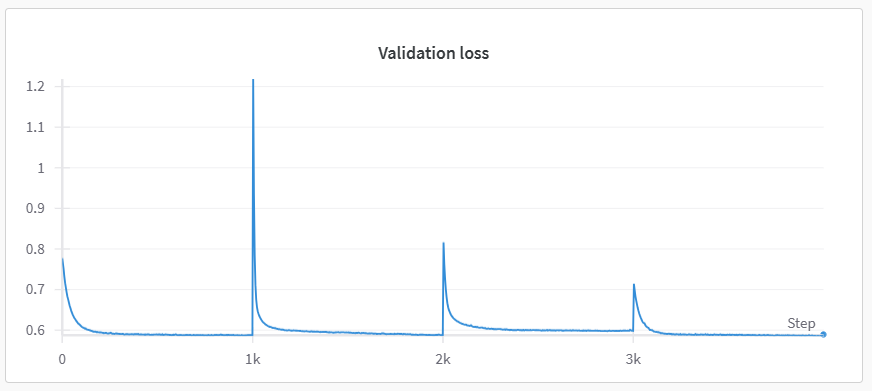

결과를 살펴보면 PReLU 모델이 Training Loss, Validation Loss 둘 다 네 모델 중에서 제일 낮은 것을 알 수 있음.
따라서 PReLU 모델이 더 나은 성능을 산출할 수 있음.

In [818]:
import torch
from torch import nn, optim
from torch.utils.data import random_split, DataLoader
from datetime import datetime
import wandb
import argparse

from pathlib import Path
BASE_PATH = "/Users/oieun/git/link_dl"

import sys
sys.path.append(BASE_PATH)

from _01_code._03_real_world_data_to_tensors.m_california_housing_dataset_dataloader \
  import CaliforniaHousingDataset

In [820]:
# 활성화 함수 리스트
activation_functions = {
    'ReLU': nn.ReLU,
    'ELU': nn.ELU,
    'LeakyReLU': nn.LeakyReLU,
    'PReLU': nn.PReLU,
}

In [822]:
def get_data():
    train_dataset, validation_dataset, _ = get_preprocessed_dataset()

    train_data_loader = DataLoader(dataset=train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset))

    return train_data_loader, validation_data_loader


In [824]:
class MyModel(nn.Module):
    def __init__(self, n_input, n_output=1, activation_fn='ReLU'):
        super().__init__()
        activation_fn = activation_functions[activation_fn]()

        self.model = nn.Sequential(
            nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
            activation_fn,
            nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
            activation_fn,
            nn.Linear(wandb.config.n_hidden_unit_list[1], n_output)
        )

    def forward(self, x):
        return self.model(x)

In [826]:
def get_model_and_optimizer(activation_fn):
    my_model = MyModel(n_input=11, n_output=1, activation_fn=activation_fn)
    optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)
    return my_model, optimizer

In [828]:
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
    n_epochs = wandb.config.epochs
    loss_fn = nn.BCEWithLogitsLoss()  # 이진 분류에 적합한 손실 함수
    next_print_epoch = 100

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        num_trains = 0

        for train_batch in train_data_loader:
            input = train_batch['input']
            target = train_batch['target'].float().view(-1, 1)  # 타겟을 float로 변환하고 차원 조정
            
            output_train = model(input)  # 모델의 출력
            loss = loss_fn(output_train, target)  # 손실 계산
            loss_train += loss.item()
            num_trains += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_validation = 0.0
        num_validations = 0
        with torch.no_grad():
            for validation_batch in validation_data_loader:
                input = validation_batch['input']
                target = validation_batch['target'].float().view(-1, 1)  # 차원 조정
                output_validation = model(input)  # 모델의 출력
                loss = loss_fn(output_validation, target)
                loss_validation += loss.item()
                num_validations += 1

        wandb.log({
            "Epoch": epoch,
            "Training loss": loss_train / num_trains,
            "Validation loss": loss_validation / num_validations,
            "Activation Function": wandb.config.activation_fn  # 활성화 함수 기록
        })

        if epoch >= next_print_epoch:
            print(
                f"Epoch {epoch}, "
                f"Training loss {loss_train / num_trains:.4f}, "
                f"Validation loss {loss_validation / num_validations:.4f}"
            )
            next_print_epoch += 100

In [830]:
def main(args):
    current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': 1e-3,
        'n_hidden_unit_list': [20, 20],
        'activation_fn': 'ReLU',  # 기본 활성화 함수
    }

    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="titanic_model_training",
        notes="Titanic Dataset with Wandb",
        tags=["titanic", "classification"],
        name=current_time_str,
        config=config
    )
    print(args)
    print(wandb.config)

    train_data_loader, validation_data_loader = get_data()

    # 다양한 활성화 함수를 실험
    for activation_name in activation_functions.keys():
        print(f"Training with activation function: {activation_name}")
        linear_model, optimizer = get_model_and_optimizer(activation_name)

        wandb.watch(linear_model)

        training_loop(
            model=linear_model,
            optimizer=optimizer,
            train_data_loader=train_data_loader,
            validation_data_loader=validation_data_loader
        )
    
    wandb.finish()

In [832]:
if __name__ == "__main__":
    if 'ipykernel' in sys.modules:
        args = argparse.Namespace(wandb=True, batch_size=512, epochs=1000)
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument("--wandb", action=argparse.BooleanOptionalAction, default=False, help="True or False")
        parser.add_argument("-b", "--batch_size", type=int, default=512, help="Batch size (int, default: 512)")
        parser.add_argument("-e", "--epochs", type=int, default=1_000, help="Number of training epochs (int, default:1_000)")
        args = parser.parse_args()

    main(args)

Epoch,▁▂▃▃▄▅▆▆▇█
Training loss,▇██▄▅▅▄▂▂▁
Validation loss,█▇▅▄▄▃▃▂▁▁
Activation Function,PReLU
Epoch,10
Training loss,0.66353
Validation loss,0.6958


Namespace(wandb=True, batch_size=512, epochs=1000)
{'epochs': 1000, 'batch_size': 512, 'learning_rate': 0.001, 'n_hidden_unit_list': [20, 20], 'activation_fn': 'ReLU'}
Training with activation function: ReLU
Epoch 100, Training loss 0.6138, Validation loss 0.6032
Epoch 200, Training loss 0.5798, Validation loss 0.5844
Epoch 300, Training loss 0.5846, Validation loss 0.5796
Epoch 400, Training loss 0.5683, Validation loss 0.5777
Epoch 500, Training loss 0.5724, Validation loss 0.5773
Epoch 600, Training loss 0.5834, Validation loss 0.5771
Epoch 700, Training loss 0.5853, Validation loss 0.5757
Epoch 800, Training loss 0.5783, Validation loss 0.5756
Epoch 900, Training loss 0.5631, Validation loss 0.5750
Epoch 1000, Training loss 0.5758, Validation loss 0.5740
Training with activation function: ELU
Epoch 100, Training loss 0.6122, Validation loss 0.6037
Epoch 200, Training loss 0.5789, Validation loss 0.5889
Epoch 300, Training loss 0.5924, Validation loss 0.5883
Epoch 400, Training loss

Epoch,▁▃▄▄▄▆▆▆▇▇█▁▂▂▃▄▅▆▆▇▂▂▃▃▃▄▄▅▅▅▇▇▁▁▂▅▆▇▇█
Training loss,▅▃▃▁▂▂▂▁▁▂▆▂▃▃▃▃▂▂▃▂▃▃█▅▃▃▃▁▂▂▆▄▄▃▃▂▃▂▃▁
Validation loss,▃▂▂▂▁▁▁▁▁▁▁▁▄▄▃▂▂▂▂▂▂▂▂█▃▃▃▃▃▃▃█▇▄▂▂▂▂▂▂
Activation Function,ReLU
Epoch,1000
Training loss,0.57514
Validation loss,0.58591


## [요구사항 3] 테스트 및 submission.csv 생성
- 요구사항 2에서 살펴본 가장 좋은 성능을 보이는 Activation Function으로 모델 구성하기
- 훈련 과정 중 어느 Epoch 시점에 테스트를 수행하여 submission.csv를 구성해야 하는지 고찰하기
  <br>• 테스트 데이터 (즉, test_data_loader) 활용 필요
- 고찰한 내용에 대한 추가 코딩 수행
- submission.csv 수행하기

https://wandb.ai/oieunxe-korea-university-of-technology-and-education/titanic_model_training

In [881]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import wandb 
import argparse
import pandas as pd
import numpy as np

In [883]:
# Titanic 데이터셋 클래스
class TitanicDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)  # 타겟을 LongTensor로 변환

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        feature = self.X[idx]
        target = self.y[idx]  # 타겟 레이블 반환
        return {'input': feature, 'target': target}

class TitanicTestDataset(Dataset):
    def __init__(self, X):
        self.X = torch.FloatTensor(X)  # 타겟 레이블 없이 피쳐만 저장

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        feature = self.X[idx]
        return {'input': feature}  # 타겟 반환하지 않음

In [885]:
# 데이터 전처리 및 로딩 함수
def get_preprocessed_dataset():
    train_df = pd.read_csv('train.csv')  # 훈련 데이터
    test_df = pd.read_csv('test.csv')    # 테스트 데이터

    # 결측치 처리
    train_df.fillna(0, inplace=True)
    test_df.fillna(0, inplace=True)

    # 원-핫 인코딩
    train_df = pd.get_dummies(train_df, drop_first=True)
    test_df = pd.get_dummies(test_df, drop_first=True)

    # 테스트 데이터와 훈련 데이터의 피쳐 수를 맞추기 위해 재정렬
    test_df = test_df.reindex(columns=train_df.columns.drop('Survived'), fill_value=0)

    # 훈련 데이터에서 피쳐와 타겟을 분리
    train_X = train_df.drop("Survived", axis=1).values  # 피쳐
    train_y = train_df["Survived"].values  # 타겟

    # 데이터 타입 확인 및 변환
    print("train_X dtype:", train_X.dtype)
    print("train_y dtype:", train_y.dtype)

    # 모든 피쳐를 float형으로 변환
    if train_X.dtype == 'object':
        train_X = train_X.astype(float)  # 피쳐를 float형으로 변환
    if train_y.dtype == 'object':
        train_y = train_y.astype(int)  # 타겟을 int형으로 변환

    # 테스트 데이터에서 피쳐만 추출
    test_X = test_df.values  # 피쳐

    # 테스트 데이터의 피쳐도 float형으로 변환
    if test_X.dtype == 'object':
        test_X = test_X.astype(float)  # 피쳐를 float형으로 변환

    # 피쳐 수 확인
    print("Number of features in train_X:", train_X.shape[1])
    print("Number of features in test_X:", test_X.shape[1])

    # PyTorch Dataset으로 변환
    train_dataset = TitanicDataset(train_X, train_y)
    validation_dataset = TitanicDataset(train_X, train_y)
    test_dataset = TitanicTestDataset(test_X)

    return train_dataset, validation_dataset, test_dataset

In [887]:
def get_data():
    train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

    train_data_loader = DataLoader(dataset=train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset))
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

    return train_data_loader, validation_data_loader, test_data_loader

In [889]:
# 모델 정의
class MyModel(nn.Module):
    def __init__(self, n_input, n_output=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, 20),
            nn.PReLU(),  # PReLU 활성화 함수 사용
            nn.Linear(20, 20),
            nn.PReLU(),
            nn.Linear(20, n_output)
        )

    def forward(self, x):
        return self.model(x)

In [891]:
def get_model_and_optimizer(n_input):
    my_model = MyModel(n_input=n_input, n_output=1)
    optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)
    return my_model, optimizer

In [893]:
def training_loop(model, optimizer, train_data_loader, validation_data_loader, test_data_loader):
    n_epochs = wandb.config.epochs
    loss_fn = nn.BCEWithLogitsLoss()  # 이진 분류에 적합한 손실 함수
    next_print_epoch = 100

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        num_trains = 0

        for train_batch in train_data_loader:
            input = train_batch['input']
            target = train_batch['target'].float().view(-1, 1)  # 타겟을 float로 변환하고 차원 조정
            
            output_train = model(input)  # 모델의 출력
            loss = loss_fn(output_train, target)  # 손실 계산
            loss_train += loss.item()
            num_trains += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_validation = 0.0
        num_validations = 0
        with torch.no_grad():
            for validation_batch in validation_data_loader:
                input = validation_batch['input']
                target = validation_batch['target'].float().view(-1, 1)  # 차원 조정
                output_validation = model(input)  # 모델의 출력
                loss = loss_fn(output_validation, target)
                loss_validation += loss.item()
                num_validations += 1

        wandb.log({
            "Epoch": epoch,
            "Training loss": loss_train / num_trains,
            "Validation loss": loss_validation / num_validations,
            "Activation Function": 'PReLU'  # 활성화 함수 기록
        })

        if epoch % 10 == 0:  # 매 10 Epoch마다 테스트 수행
            test_model(model, test_data_loader)

        if epoch >= next_print_epoch:
            print(
                f"Epoch {epoch}, "
                f"Training loss {loss_train / num_trains:.4f}, "
                f"Validation loss {loss_validation / num_validations:.4f}"
            )
            next_print_epoch += 100

In [895]:
def test_model(model, test_data_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for test_batch in test_data_loader:
            input = test_batch['input']
            output = model(input)
            predictions.extend(torch.sigmoid(output).numpy().flatten())  # 확률로 변환하여 예측 추가

    # NumPy 배열로 변환
    predictions = np.array(predictions)

    # submission.csv 파일 생성
    submission = pd.DataFrame({
        'PassengerId': range(892, 892 + len(predictions)), 
        'Survived': (predictions > 0.5).astype(int)  # NumPy 배열로 비교
    })
    submission.to_csv('submission.csv', index=False)

In [897]:
def main(args):
    current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': 1e-3,
        'n_hidden_unit_list': [20, 20],
        'activation_fn': 'PReLU',  # PReLU 사용
    }

    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="titanic_model_training",
        notes="Titanic Dataset with Wandb",
        tags=["titanic", "classification"],
        name=current_time_str,
        config=config
    )
    print(args)
    print(wandb.config)

    train_data_loader, validation_data_loader, test_data_loader = get_data()
    
    # 피쳐 수 가져오기
    n_input = train_data_loader.dataset.X.shape[1]
    linear_model, optimizer = get_model_and_optimizer(n_input)

    wandb.watch(linear_model)

    training_loop(
        model=linear_model,
        optimizer=optimizer,
        train_data_loader=train_data_loader,
        validation_data_loader=validation_data_loader,
        test_data_loader=test_data_loader
    )
    
    wandb.finish()

In [899]:
if __name__ == "__main__":
    if 'ipykernel' in sys.modules:
        args = argparse.Namespace(wandb=True, batch_size=512, epochs=1000)
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument("--wandb", action=argparse.BooleanOptionalAction, default=False, help="True or False")
        parser.add_argument("-b", "--batch_size", type=int, default=512, help="Batch size (int, default: 512)")
        parser.add_argument("-e", "--epochs", type=int, default=1_000, help="Number of training epochs (int, default: 1_000)")
        args = parser.parse_args()

    main(args)


Namespace(wandb=True, batch_size=512, epochs=1000)
{'epochs': 1000, 'batch_size': 512, 'learning_rate': 0.001, 'n_hidden_unit_list': [20, 20], 'activation_fn': 'PReLU'}
train_X dtype: object
train_y dtype: int64
Number of features in train_X: 1727
Number of features in test_X: 1727
Epoch 100, Training loss 0.6661, Validation loss 0.6531
Epoch 200, Training loss 0.6232, Validation loss 0.6227
Epoch 300, Training loss 0.6366, Validation loss 0.6328
Epoch 400, Training loss 0.6150, Validation loss 0.6158
Epoch 500, Training loss 0.6460, Validation loss 0.6443
Epoch 600, Training loss 0.6193, Validation loss 0.6194
Epoch 700, Training loss 0.6204, Validation loss 0.6245
Epoch 800, Training loss 0.6085, Validation loss 0.6086
Epoch 900, Training loss 0.6276, Validation loss 0.6462
Epoch 1000, Training loss 0.6183, Validation loss 0.6085


Epoch,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
Training loss,█▇▄▃▄▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▃▁▄▁▂▂▁▁▅▃▁▁▁▁▁▁
Validation loss,█▄▄▃▄▃▃▅▂▂▃▂▃▄▂▃▃▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▆▂▁▁▂▁▁
Activation Function,PReLU
Epoch,1000
Training loss,0.61834
Validation loss,0.60853


#### [요구사항 3] Wandb 제출페이지
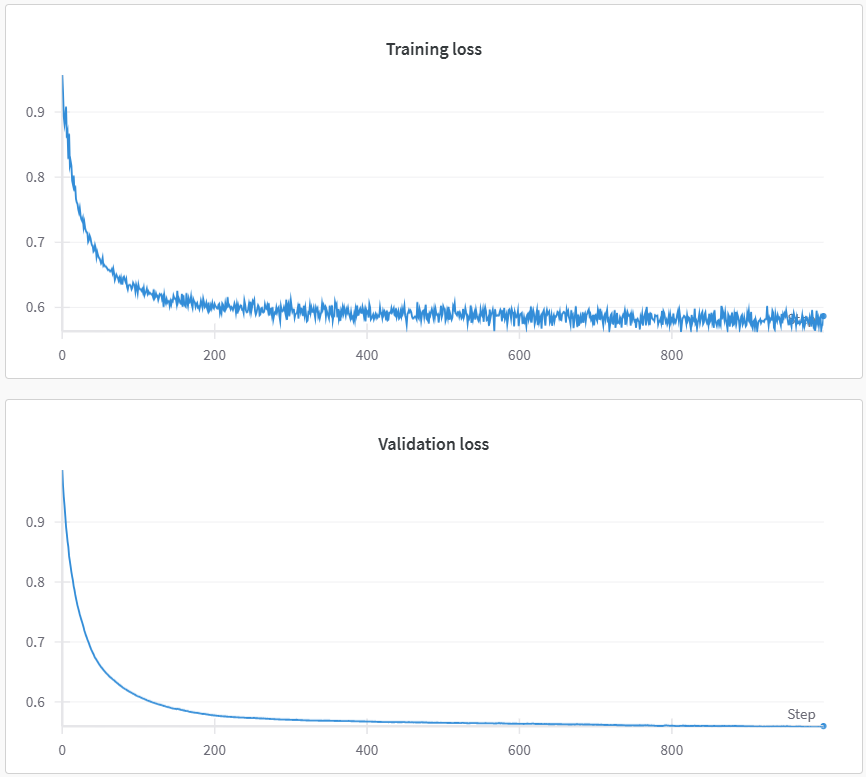

submission.csv를 생성하기 위해 어떤 Epoch 시점에 테스트를 수행해야 할지에 대한 고찰은 모델 성능, 데이터셋의 특성, 프로젝트의 목적에 따라 달라질 수 있다.<br>
<br>
1. 모델 성능 모니터링<br>
조기 종료 (Early Stopping): 모델이 성능을 향상시키지 못할 경우 조기 종료를 고려할 수 있다. 이 경우, 특정 Epoch마다 모델의 성능을 평가하여 최적의 성능을 보이는 시점에서 submission.csv를 생성하는 것이 좋다.<br>
검증 손실: 각 Epoch마다 검증 손실을 기록하고, 손실이 감소하는 시점에서 테스트를 수행하는 것이 유리하다.<br>
2. 테스트 주기<br>
주기적 테스트: 현재 코드에서는 매 10 Epoch마다 테스트를 수행하도록 설정되어 있다. 이를 통해 모델이 학습하는 동안의 성능 변화를 관찰할 수 있다. 그러나 너무 자주 테스트를 수행하면 시간이 낭비될 수 있다.<br>
최종 테스트: 모든 Epoch이 완료된 후, 최종적인 모델 성능을 평가하는 것도 좋다. 이 경우, 마지막 Epoch에서 테스트를 수행하여 submission.csv를 생성하는 것이 일반적이다.<br>
3. 모델의 학습 상태<br>
오버피팅 감지: 훈련 손실은 계속 감소하지만 검증 손실이 증가하는 경우, 모델이 오버피팅되고 있다는 신호일 수 있다. 이 경우, 마지막 검증 손실이 가장 낮은 시점에서 테스트를 수행하는 것이 좋다.

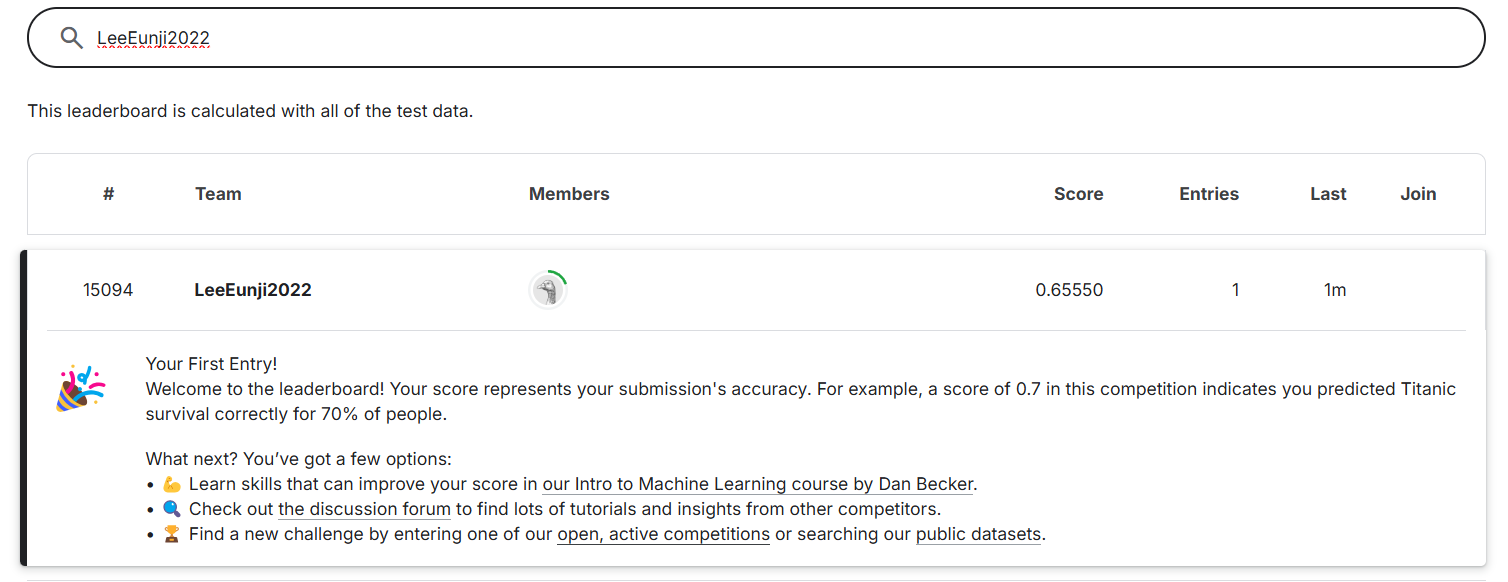

#### submission.csv 제출 및 등수 확인 이미지 링크
https://drive.google.com/file/d/1LDXpynjZE9Pp6YCaVpgxq1vZpdGfunED/view

## 숙제 후기
졸업설계 때 딥러닝을 사용할 예정이라 이번 과제의 학습이 도움이 되었습니다. 하지만, 내용이 저에게는 너무 어려워서 힘들기도 했습니다. Wandb, 캐글 모두 처음 사용해보는 거라 사람들의 도움을 많이 받았습니다. 앞으로도 열심히 학습하겠습니다!